# Generative Adversarial Network (GAN)

![](https://nbviewer.jupyter.org/github/hse-aml/intro-to-dl/blob/master/week4/images/gan.png)

Пришло время поговорить о более интересных архитектурах, а именно о GANах или состязательных нейронных сетках. [Впервые GANы были предложены в 2014 году.](https://arxiv.org/abs/1406.2661) Сейчас они очень активно исследуются. GANы состоят из двух нейронных сетей: 

* Первая - генератор порождает из некоторого заданного распределения случайные числа и собирает из них объекты, которые идут на вход второй сети. 
* Вторая - дискриминатор получает на вход объекты из реальной выборки и объекты, созданные генератором. Она пытается определить какой объект был порождён генератором, а какой является реальным.

Таким образом генератор пытается создавать объекты, которые дискриминатор не сможет отличить от реальных. 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import numpy as np
import time 

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!nvidia-smi

Mon Sep 13 13:43:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Данные

Для начала давайте попробуем погонять модели на рукописных цифрах из MNIST как бы скучно это не было. 

In [4]:
(X, _ ), (_, _) = tf.keras.datasets.mnist.load_data()

In [5]:
X = X/127.5 - 1 # отнормировали данные на отрезок [-1, 1]

In [6]:
X.min(), X.max()  # проверили нормировку

(-1.0, 1.0)

In [7]:
X = X[:,:,:,np.newaxis]
X.shape

(60000, 28, 28, 1)

Давайте вытащим несколько рандомных картинок и нарисуем их.

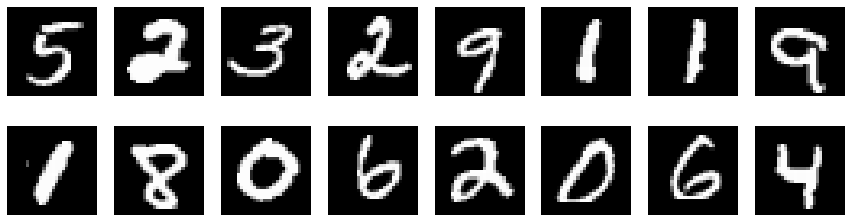

In [8]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, X.shape[0])
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(np.squeeze(X,-1)[random_index, :], cmap='gray')
plt.show()

Соберём для наших данных удобный генератор. 

# 2. Дискриминатор 

* Дискриминатор - это обычная свёрточная сетка 
* Цель этой сетки - отличать сгенерированные изображения от реальных

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as L

In [10]:
IMG_SHAPE = X.shape[1:]

In [11]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))
discriminator.add(L.Conv2D(16, kernel_size=(3,3), activation='elu', padding='same'))
discriminator.add(L.MaxPool2D())

discriminator.add(L.Conv2D(32, kernel_size=(3,3), activation='elu', padding='same'))
discriminator.add(L.MaxPool2D())

discriminator.add(L.Flatten())
discriminator.add(L.Dense(128,activation='tanh'))

discriminator.add(L.Dense(1))

# 3. Генератор

* Генерирует из шума изображения 

Будем генерировать новые цифры из шума размера `code_size`.

In [12]:
CODE_SIZE = 128

In [13]:
generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(128*7*7, activation='elu'))
generator.add(L.Reshape((7,7,128)))
generator.add(L.Conv2DTranspose(128, kernel_size=(3,3)))
generator.add(L.LeakyReLU())
generator.add(L.Conv2DTranspose(64, kernel_size=(3,3)))
generator.add(L.LeakyReLU())
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2D(1, kernel_size=3, padding='same'))
generator.output_shape == (None, 28, 28, 1)

True

In [14]:
generator.output_shape

(None, 28, 28, 1)

Посмотрим на пример, который нам генерирует на выход наша свежая нейронка! 

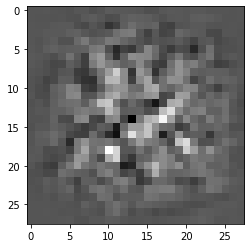

In [15]:
noise = tf.random.normal([1, CODE_SIZE])
generated_image = generator(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray');

Хммм... А что про это всё думает дескриминатор?

In [16]:
decision = discriminator(generated_image)

# на выход из дискриминатора мы забираем логарифм!
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.05667955]], dtype=float32)>

# 4. Функция потерь 

Потери для дескриминатора это обычныя кросс-энтропия.

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output)+0.05 * np.random.random(real_output.shape),
                              real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output)+0.05 * np.random.random(fake_output.shape),
                              fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
real_output = discriminator(X[0:10])
fake_output = discriminator(generated_image)

discriminator_loss(real_output, fake_output)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4538573>

Для генератора мы хотим максимизировать ошибку дискриминатора на фэйковых примерах. 

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
generator_loss(fake_output)

<tf.Tensor: shape=(), dtype=float32, numpy=0.66520894>

# 5. Градиентный спуск

Учить пару из сеток будем так: 

* Делаем $k$ шагов обучения дискриминатора. Целевая переменная - реальный объект перед нами или порождённый. Веса изменяем стандартно, пытаясь уменьшить кросс-энтропию.
* Делаем $m$ шагов обучения генератора. Веса внутри сетки меняем так, чтобы увеличить логарифм вероятности дискриминатора присвоить сгенерированному объекту лэйбл реального. 
* Обучаем итеративно до тех пор, пока дискриминатор больше не сможет найти разницу (либо пока у нас не закончится терпение).
* При обучении может возникнуть огромное количество пробем от взрыва весов до более тонких вещей. Имеет смысл посмотреть на разные трюки, используемые при обучении:  https://github.com/soumith/ganhacks

Собираем структуру для обучения.

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


Чекпойнты для процесса обучения.

In [23]:
import os 
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Задаём один шаг процедуры обучения генератора.

In [24]:
@tf.function
def train_generator_step(images, noise):

    # ищем градиенты 
    with tf.GradientTape() as gen_tape:
        
        # сгенерировали новое изображение из шума
        generated_images = generator(noise)
        
        # посчитали прогнозы дискриминатора
        #real_output = discriminator(images)
        fake_output = discriminator(generated_images)
        
        # нашли ошибку
        gen_loss = generator_loss(fake_output)
        
    # нашли градиенты
    grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
        
    # сделали шаг градиентного спуска 
    generator_optimizer.apply_gradients(zip(grad, generator.trainable_variables))

Теперь шаг обучения дискриминатора. 

In [25]:
@tf.function
def train_discriminator_step(images, noise):
    
    # ищем градиенты 
    with tf.GradientTape() as disc_tape:
        
        # сгенерировали новое изображение из шума
        generated_images = generator(noise)
        
        # посчитали прогнозы дискриминатора
        real_output = discriminator(images)
        fake_output = discriminator(generated_images)
        
        # нашли ошибку
        disc_loss = discriminator_loss(real_output, fake_output)
        
    # нашли градиенты
    grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
    # сделали шаг градиентного спуска 
    discriminator_optimizer.apply_gradients(zip(grad, discriminator.trainable_variables))

Мы почти готовы учить нашу сетку. Напишем две простенькие функции для генерации фэйковых и настоящих батчей. 

In [26]:
# функция, которая генерирует батч с шумом
def sample_noise_batch(bsize):
    return tf.random.normal([bsize, CODE_SIZE], dtype=tf.float32)


# функция, которая генерирует батч из реальных данных (для баловства)
def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(X.shape[0]), size=bsize)
    return X[idxs]

Проверяем отрабатывают ли наши шаги.

In [27]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 1.4382617
Ошибка генератора: 0.6874545


In [28]:
# сделали шаг работы генератора
train_generator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 1.4526877
Ошибка генератора: 0.6723995


In [29]:
# сделали шаг работы дискриминатора
train_discriminator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 1.2604051
Ошибка генератора: 0.67459273


Как думаете, выглядит адекватно? Мы нигде не ошиблись? 

Напишем пару вспомогательных функций для отрисовки картинок. 

In [30]:
# рисуем изображения
def sample_images(rows, cols, num=0):
    images = generator.predict(sample_noise_batch(bsize=rows*cols))
    
    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(np.squeeze(images[i * rows + j],-1),cmap='gray')
    
    # сохраняем картинку для гифки
    #if num >0:
     #   plt.savefig('images_gan/image_at_epoch_{:04d}.png'.format(num))
    plt.show()
    


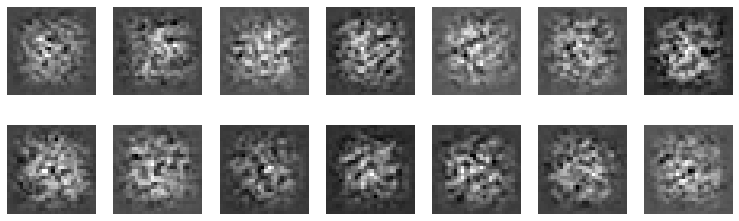

In [31]:
sample_images(2,7)

Немного побалуемся с шагами. 

In [32]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

# Генератор
train_generator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 1.2584004
Ошибка генератора: 0.670801


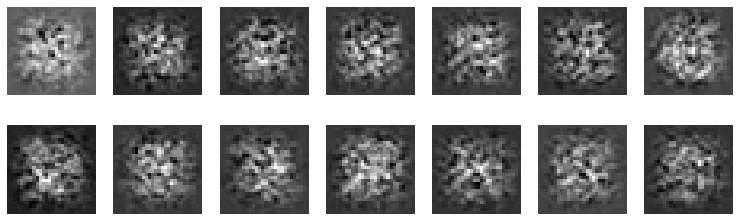

In [33]:
sample_images(2,7)

In [34]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

# Дискриминатор
train_discriminator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 1.1055133
Ошибка генератора: 0.6798461


# 6. Обучение

Ну и наконец последний шаг. Тренировка сеток.  При обучении нужно соблюдать между сетками баланс. Важно сделать так, чтобы ни одна из них не стала сразу же побеждать. Иначе обучение остановится. 

* Чтобы избежать моментального выигрыша дискриминатора, мы добавили в его функцию потерь $l_2$ регуляризацию. 
* Кроме регуляризации можно пытаться учить модели сбалансированно, делая внутри цикла шаги чуть более умным способом. 


In [35]:
# Эксперименты с совместным обучением (так цикл работает быстре)
@tf.function
def train_step(images, noise):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        
        real_output = discriminator(images)
        fake_output = discriminator(generated_images)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) 

Time for epoch 1 is 0.020498894155025482 min
error D: 1.1058586835861206, error G: 0.6798461079597473


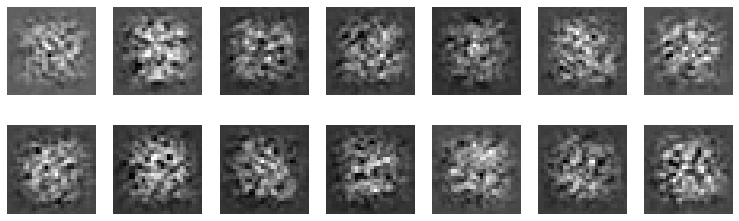

Time for epoch 51 is 0.2822328507900238 min
error D: 1.1070109605789185, error G: 0.6798461079597473


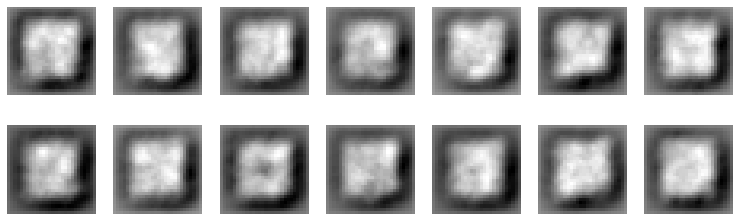

Time for epoch 101 is 0.5403329916298389 min
error D: 1.1061475276947021, error G: 0.6798461079597473


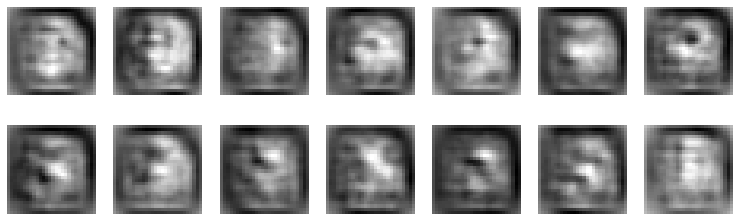

Time for epoch 151 is 0.7983447015285492 min
error D: 1.1061817407608032, error G: 0.6798461079597473


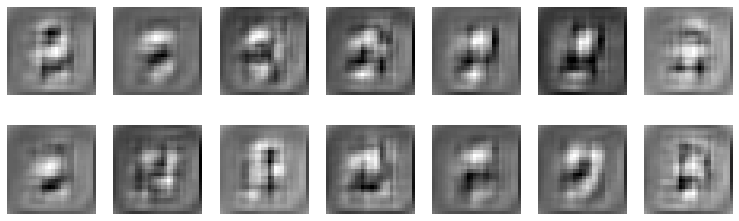

Time for epoch 201 is 1.0590323247015476 min
error D: 1.1061134338378906, error G: 0.6798461079597473


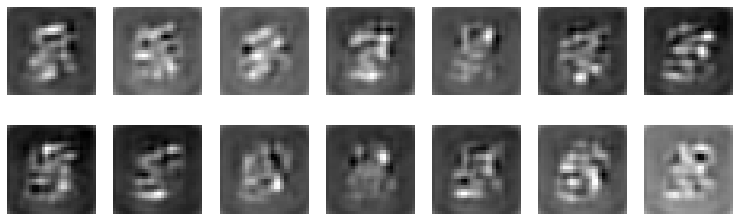

Time for epoch 251 is 1.3158467151224613 min
error D: 1.1082110404968262, error G: 0.6798461079597473


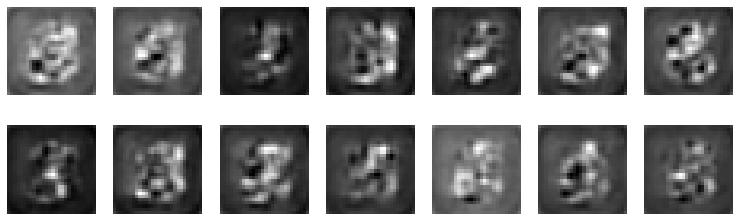

Time for epoch 301 is 1.5728071853518486 min
error D: 1.1063510179519653, error G: 0.6798461079597473


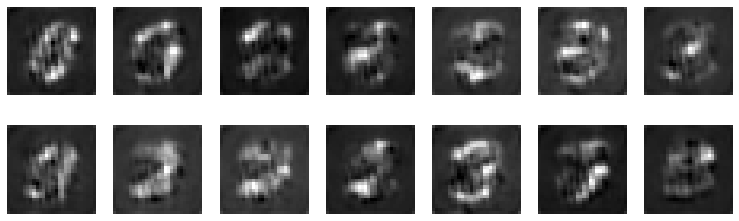

Time for epoch 351 is 1.8302453085780144 min
error D: 1.106571078300476, error G: 0.6798461079597473


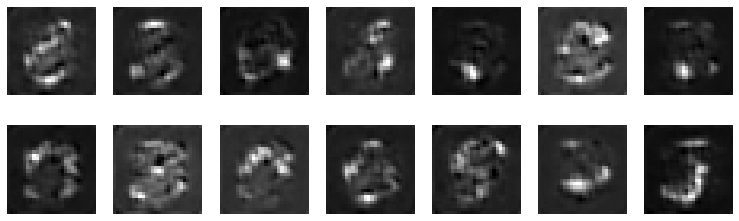

Time for epoch 401 is 2.09110951051116 min
error D: 1.1068894863128662, error G: 0.6798461079597473


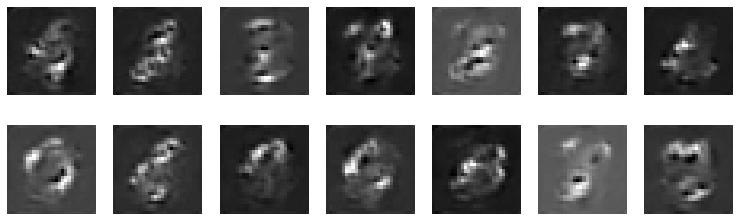

Time for epoch 451 is 2.3476423770189285 min
error D: 1.1072522401809692, error G: 0.6798461079597473


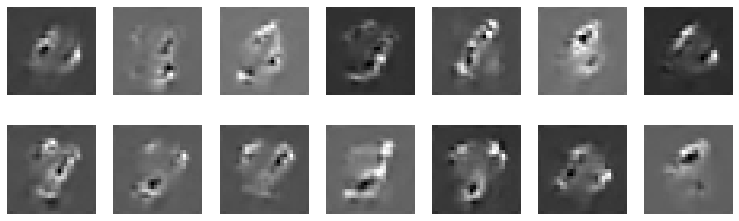

Time for epoch 501 is 2.605098392814398 min
error D: 1.105478048324585, error G: 0.6798461079597473


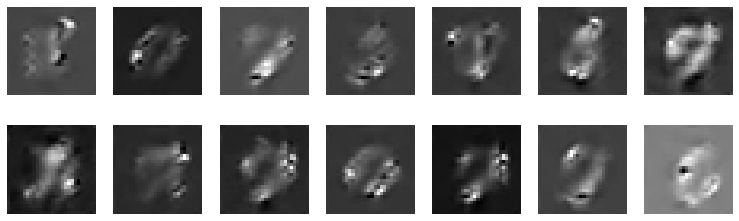

Time for epoch 551 is 2.861828349530697 min
error D: 1.104910135269165, error G: 0.6798461079597473


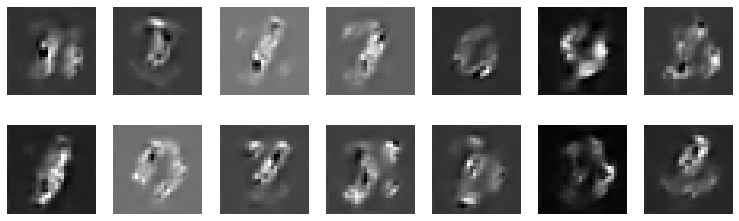

Time for epoch 601 is 3.1211285181343555 min
error D: 1.1063520908355713, error G: 0.6798461079597473


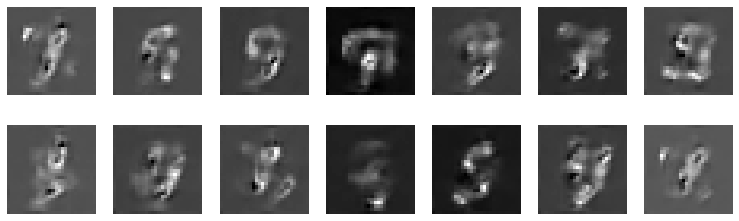

Time for epoch 651 is 3.3780425414443016 min
error D: 1.106021523475647, error G: 0.6798461079597473


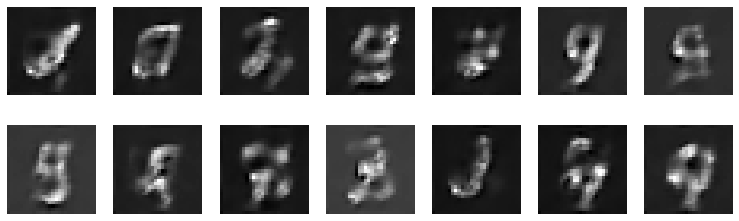

Time for epoch 701 is 3.634583979845047 min
error D: 1.106282353401184, error G: 0.6798461079597473


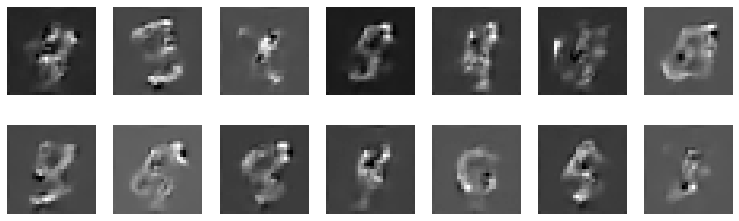

Time for epoch 751 is 3.8942590057849884 min
error D: 1.1066696643829346, error G: 0.6798461079597473


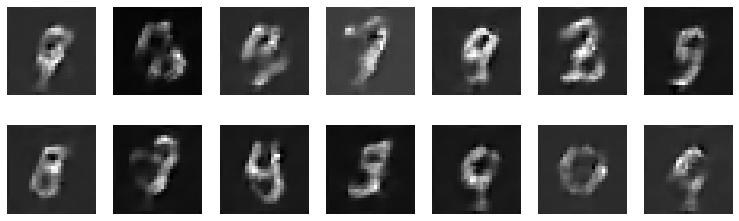

Time for epoch 801 is 4.1512048207223415 min
error D: 1.1056523323059082, error G: 0.6798461079597473


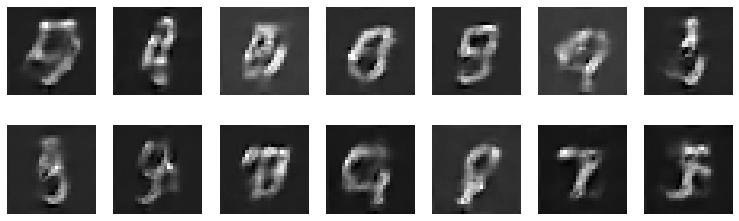

Time for epoch 851 is 4.407529763877392 min
error D: 1.105867862701416, error G: 0.6798461079597473


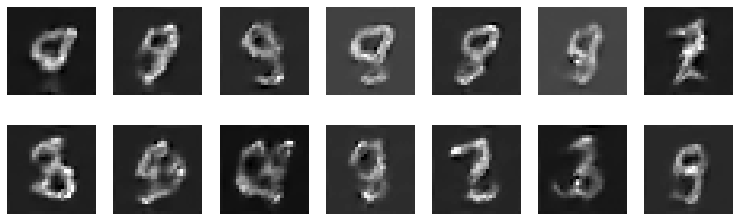

Time for epoch 901 is 4.66382572427392 min
error D: 1.1059985160827637, error G: 0.6798461079597473


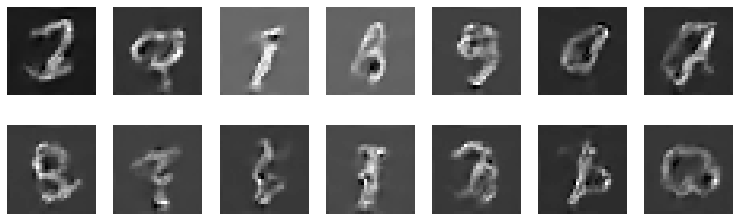

Time for epoch 951 is 4.9245517663657665 min
error D: 1.1055424213409424, error G: 0.6798461079597473


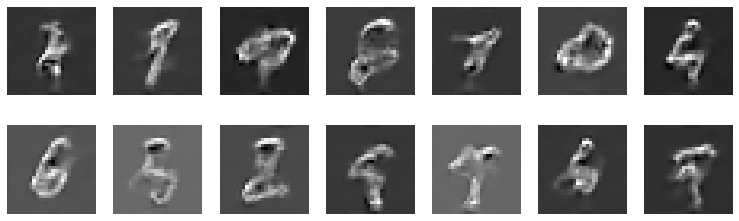

Time for epoch 1001 is 5.181636393070221 min
error D: 1.1060925722122192, error G: 0.6798461079597473


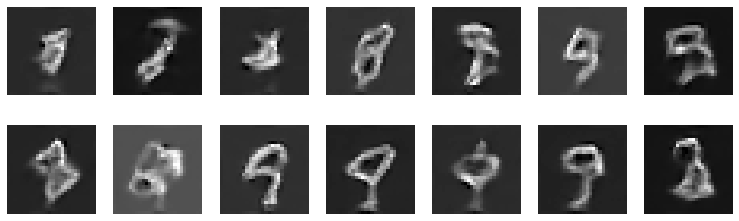

Time for epoch 1051 is 5.438104692846537 min
error D: 1.1078730821609497, error G: 0.6798461079597473


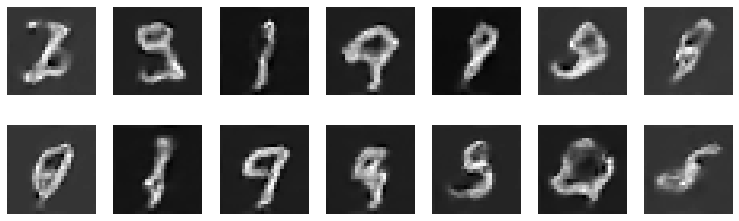

Time for epoch 1101 is 5.694736808538437 min
error D: 1.106818675994873, error G: 0.6798461079597473


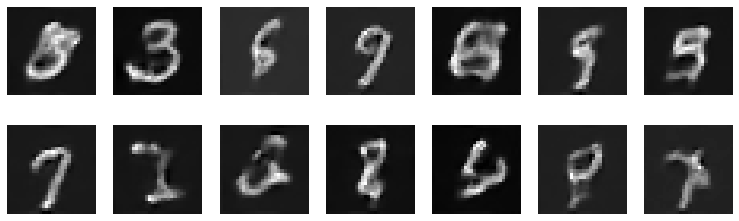

Time for epoch 1151 is 5.955183625221252 min
error D: 1.1061022281646729, error G: 0.6798461079597473


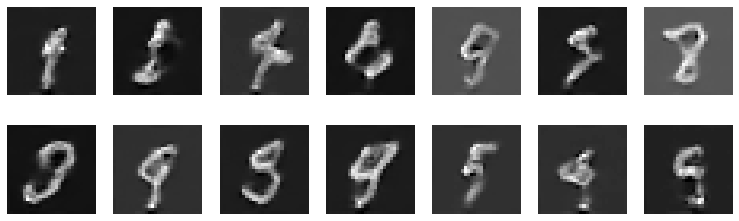

Time for epoch 1201 is 6.212540715932846 min
error D: 1.10647451877594, error G: 0.6798461079597473


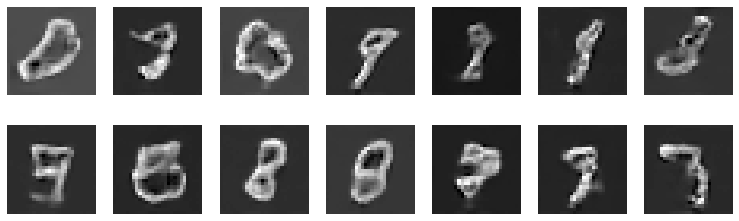

Time for epoch 1251 is 6.469487261027098 min
error D: 1.106446385383606, error G: 0.6798461079597473


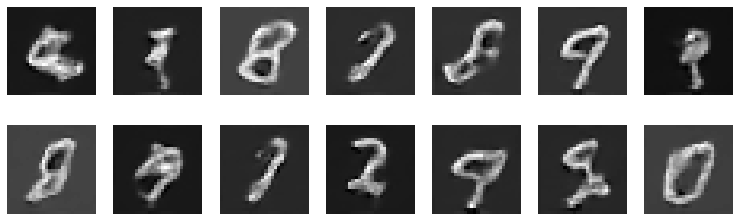

Time for epoch 1301 is 6.728964548557997 min
error D: 1.106161117553711, error G: 0.6798461079597473


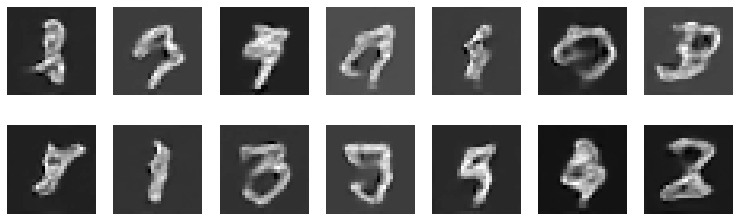

Time for epoch 1351 is 6.986194606870413 min
error D: 1.1059982776641846, error G: 0.6798461079597473


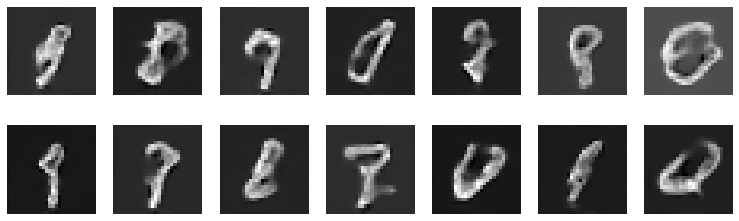

Time for epoch 1401 is 7.242515467107296 min
error D: 1.107547402381897, error G: 0.6798461079597473


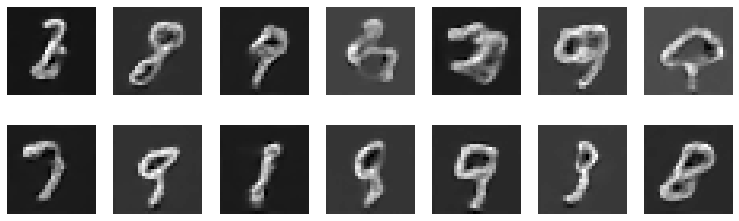

Time for epoch 1451 is 7.4986289739608765 min
error D: 1.1066824197769165, error G: 0.6798461079597473


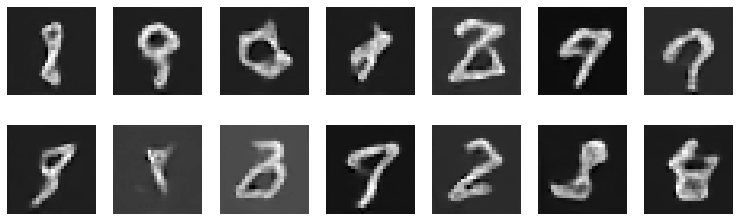

Time for epoch 1501 is 7.758781164884567 min
error D: 1.1060121059417725, error G: 0.6798461079597473


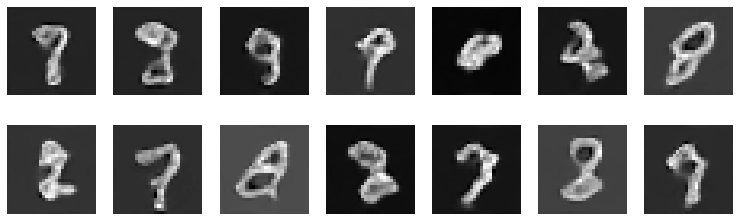

Time for epoch 1551 is 8.015224248170853 min
error D: 1.1058294773101807, error G: 0.6798461079597473


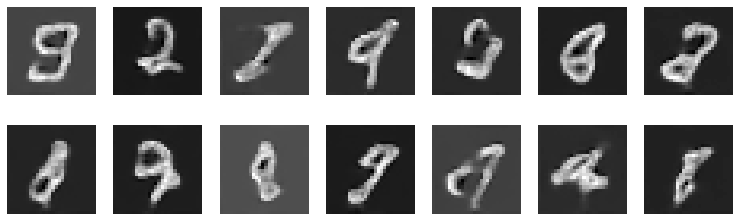

Time for epoch 1601 is 8.27186893671751 min
error D: 1.106170415878296, error G: 0.6798461079597473


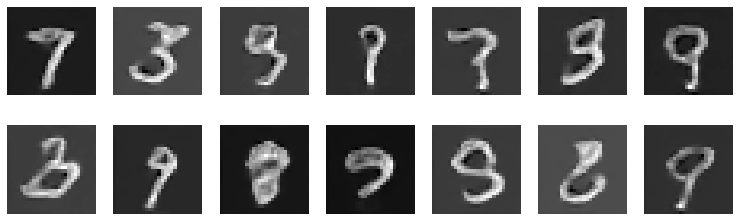

Time for epoch 1651 is 8.52840393781662 min
error D: 1.1058992147445679, error G: 0.6798461079597473


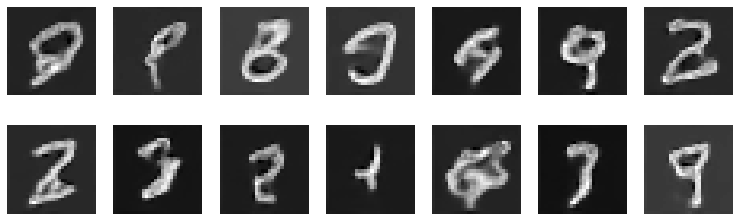

Time for epoch 1701 is 8.788202997297049 min
error D: 1.1073297262191772, error G: 0.6798461079597473


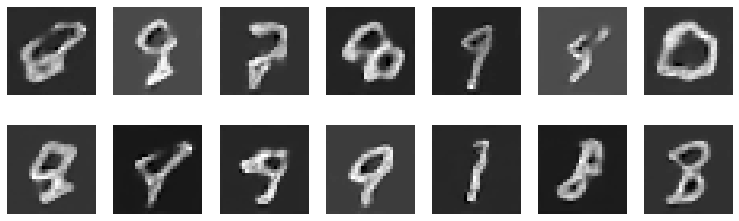

Time for epoch 1751 is 9.045145284384489 min
error D: 1.106472134590149, error G: 0.6798461079597473


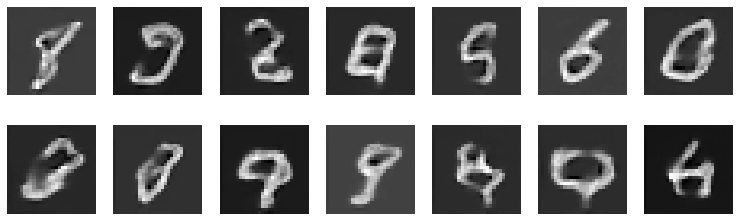

Time for epoch 1801 is 9.301188662648201 min
error D: 1.1055152416229248, error G: 0.6798461079597473


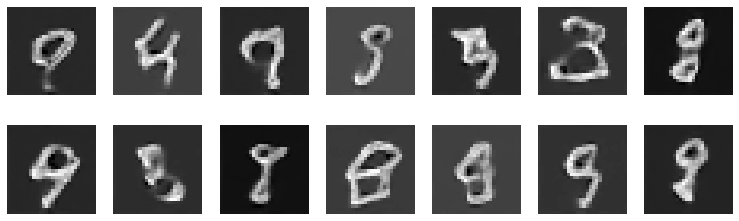

Time for epoch 1851 is 9.561576399952173 min
error D: 1.1053155660629272, error G: 0.6798461079597473


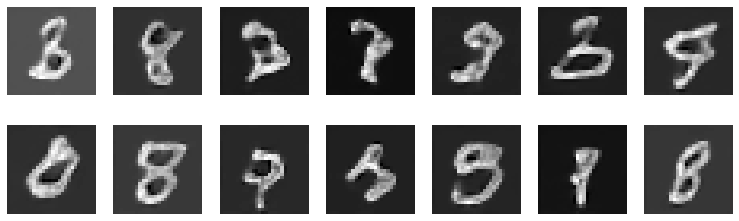

Time for epoch 1901 is 9.81764830648899 min
error D: 1.10626220703125, error G: 0.6798461079597473


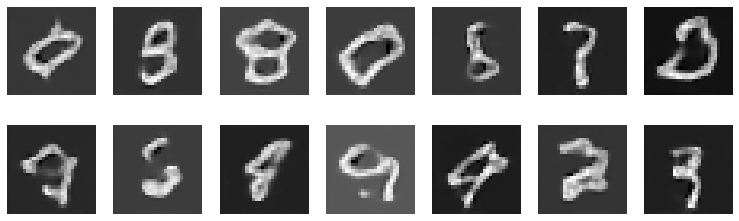

Time for epoch 1951 is 10.074444450438023 min
error D: 1.1070020198822021, error G: 0.6798461079597473


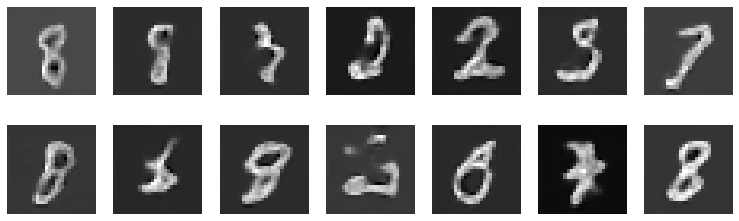

In [36]:
from IPython import display

EPOCHS = 2000
BSIZE = 256

# время
start = time.time()/60

# вектора для мониторинга сходимости сеток
d_losses = [ ]
g_losses = [ ]

num = 0 # для сохранения картинок 

# запускаем цикл обучения 
for epoch in range(EPOCHS):
    
    # генерируем батч
    X_batch = sample_data_batch(BSIZE)
    X_fake = sample_noise_batch(BSIZE)
    


    train_step(X_batch, X_fake)
       # делаем N шагов обучения дискриминатора
    for i in range(5):
        train_discriminator_step(X_batch, X_fake)
        
    # делаем K шагов обучения генератора
    for i in range(1):
        train_generator_step(X_batch, X_fake)
    
#     gen_log = discriminator(generator(X_fake))
#     real_log = discriminator(X_batch) 
    
    d_losses.append(discriminator_loss(real_log, gen_log).numpy())
    g_losses.append(generator_loss(gen_log).numpy())
        
    # ну сколько можно ждааать!!! 
    if epoch % 50==0:
        print('Time for epoch {} is {} min'.format(epoch + 1, time.time()/60-start))
        print('error D: {}, error G: {}'.format(d_losses[-1], g_losses[-1]))

    if epoch % 50==0:
        # сохраняем модель и обновляем картинку
        # checkpoint.save(file_prefix = checkpoint_prefix)

        # можно раскоментировать, если хочется, чтобы картинка обновлялась, а не дополнялас
        #display.clear_output(wait=True)
        num += 1
        sample_images(2,7, num)
#         sample_probas(X_batch)

Тренируем сетки.

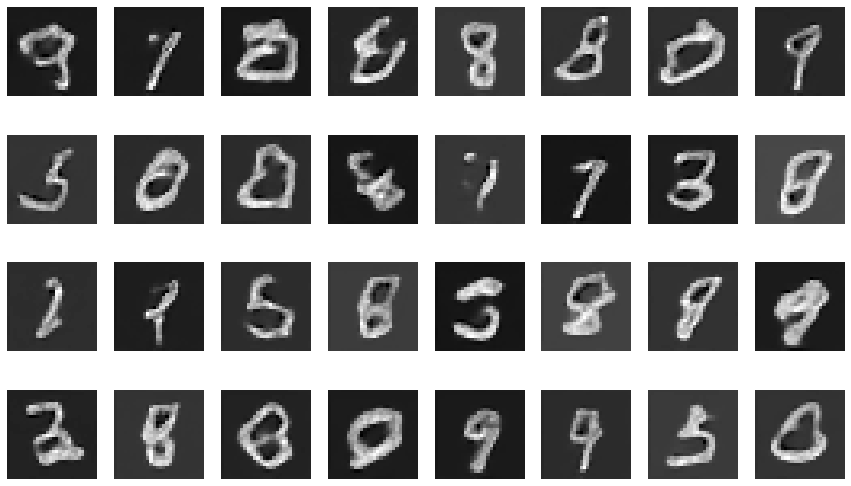

In [37]:
# сетка тренировалась много итераций
sample_images(4,8)  

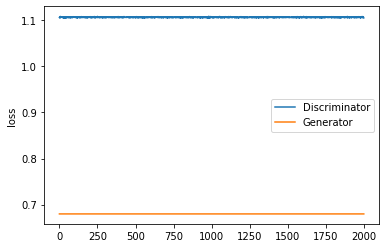

In [38]:
# смотрим сошлись ли потери
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.ylabel('loss')
plt.legend();

А что мы вообще сгенерировали?! Давайте посмотрим на точку из выборки наиболее близкую к получившейся генерации.

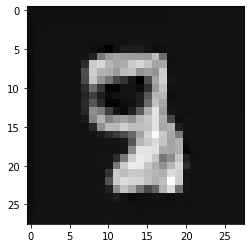

In [39]:
id_label_sample = 8
img_smp = generator.predict(sample_noise_batch(1))
plt.imshow(img_smp[0,:,:,0], cmap='gray')

In [40]:
img_smp.shape, X.shape

((1, 28, 28, 1), (60000, 28, 28, 1))

In [41]:
# ищем l1 норму между тем, что сгенерилось и остальным 
L1d = np.sum(np.sum(np.abs(X[:,:,:,0] - img_smp[:,:,:,0]), axis=1), axis=1)
idx_l1_sort = L1d.argsort()
idx_l1_sort.shape

(60000,)

In [42]:
idx_l1_sort[:5]

array([17574, 41762,  2550,  1836, 15424])

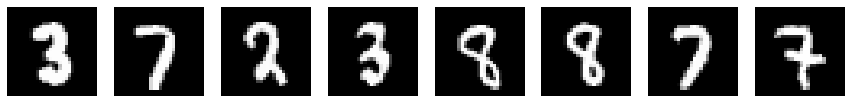

In [43]:
N_closest = 8

fig = plt.figure(figsize=(15,4))
for i in range(N_closest):
    ax = fig.add_subplot(1, N_closest, i+1)
    ax.grid('off')
    ax.axis('off')
    ax.imshow(X[idx_l1_sort[i], :, :, 0], cmap='gray')
plt.show()

На этом всё :) В качесте ДЗ попробуйте поэкспериментировать и сделать свой GAN на какой-нибудь другой архитектуре

![](https://miro.medium.com/max/896/1*3VOLkgm-QY05gEpGDkBzTA.gif)